In [1]:
"""
Grid preparation for future aspen project:

Author: maxwell.cook@colorado.edu
"""

import os, sys, time, re
import pandas as pd
import xarray as xr
import geopandas as gpd
import numpy as np
import rasterio as rio
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import distance_transform_edt

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/')

# Custom functions
sys.path.append(os.path.join(maindir,'aspen-fire/Aim2/code/Python'))
from __functions import *

proj = 'EPSG:5070' # albers

print("Ready to go !")

Ready to go !


In [2]:
# load the firesheds
fp = os.path.join(projdir,'Aim3/data/spatial/raw/fsim/firesheds/subfiresheds.gpkg')
firesheds = gpd.read_file(fp)
print(firesheds.columns)
print(len(firesheds))

Index(['OBJECTID', 'Fireshed_ID', 'Subfireshed_ID', 'Fireshed_Area_Ha',
       'Subfireshed_Area_Ha', 'Fireshed_Name', 'Fireshed_Code',
       'Fireshed_State', 'Shape_Length', 'Shape_Area', 'Fireshed_MajRegion',
       'AnnualExposure', 'PctRecentlyDisturbed', 'geometry'],
      dtype='object')
1714


In [3]:
# tidy the dataframe
firesheds.drop(
    columns=[
        'OBJECTID','Fireshed_State',
        'Shape_Length','Shape_Area',
        'Fireshed_Area_Ha','Fireshed_Code',
        'Fireshed_MajRegion'
    ], inplace=True
)
firesheds.rename(
    columns={
        'Fireshed_ID': 'fs_id',
        'Fireshed_Name': 'fs_name',
        'Subfireshed_ID': 'sfs_id',
        'Subfireshed_Area_Ha': 'sfs_area_ha',
        'AnnualExposure': 'sfs_exposure',
        'PctRecentlyDisturbed': 'pct_disturbed'
    }, inplace=True
)
# check the results
firesheds.head()

,fs_id,sfs_id,sfs_area_ha,fs_name,sfs_exposure,pct_disturbed,geometry
0,2039,20466,10147.68,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1175586.440 1748339.700, -117..."
1,2039,20467,10380.96,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1165866.440 1748339.700, -116..."
2,2039,20468,10730.88,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1180986.440 1737539.700, -118..."
3,2039,20469,11314.08,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1169106.440 1737539.700, -116..."
4,2097,21025,10964.16,"Indian Village, Utah",0.001366,9.739679,"MULTIPOLYGON (((-1174506.440 1727819.700, -117..."


## Future Fire

From Stephens et al., In review, annual probability of area burned and fire occurrence by US EPA Level IV ecoregion. Trend to 2060 was calculated using a median-based linear model (MBLM) thielsen estimate. 

In [4]:
# join to Level IV ecoregion
fp = os.path.join(projdir,'Aim3/data/spatial/mod/future_fire_ecol4_trend.gpkg')
ecol4 = gpd.read_file(fp)
ecol4.columns

Index(['US_L4CODE', 'US_L4NAME', 'US_L3CODE', 'US_L3NAME', 'NA_L3CODE',
       'NA_L3NAME', 'NA_L2CODE', 'NA_L2NAME', 'NA_L1CODE', 'NA_L1NAME',
       'L4_KEY', 'L3_KEY', 'L2_KEY', 'L1_KEY', 'Shape_Leng', 'Shape_Area',
       'trend_area', 'p_area', 'trend_count', 'p_count', 'geometry'],
      dtype='object')

In [5]:
# calculate the majority overlapping level IV ecoregion
overlap = gpd.overlay(firesheds, ecol4, how='intersection')
overlap['area'] = overlap.geometry.area # get the total area
cols = ['sfs_id','US_L4CODE','US_L4NAME','trend_area','trend_count']
sum = overlap.groupby(cols)['area'].sum().reset_index() # get the area sum
maj = sum.loc[sum.groupby('sfs_id')['area'].idxmax()] # get the largest area
# merge back to firesheds
firesheds = firesheds.merge(maj[cols], on='sfs_id', how='left')
firesheds.head()

,fs_id,sfs_id,sfs_area_ha,fs_name,sfs_exposure,pct_disturbed,geometry,US_L4CODE,US_L4NAME,trend_area,trend_count
0,2039,20466,10147.68,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1175586.440 1748339.700, -117...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504
1,2039,20467,10380.96,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1165866.440 1748339.700, -116...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504
2,2039,20468,10730.88,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1180986.440 1737539.700, -118...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504
3,2039,20469,11314.08,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1169106.440 1737539.700, -116...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504
4,2097,21025,10964.16,"Indian Village, Utah",0.001366,9.739679,"MULTIPOLYGON (((-1174506.440 1727819.700, -117...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504


In [6]:
len(firesheds)

1714

## Aspen habitat suitability 

From Hart et al. In Review- Calculate the change between past and future (2041-2070) aspen suitability to get the difference (future change in habitat suitability).

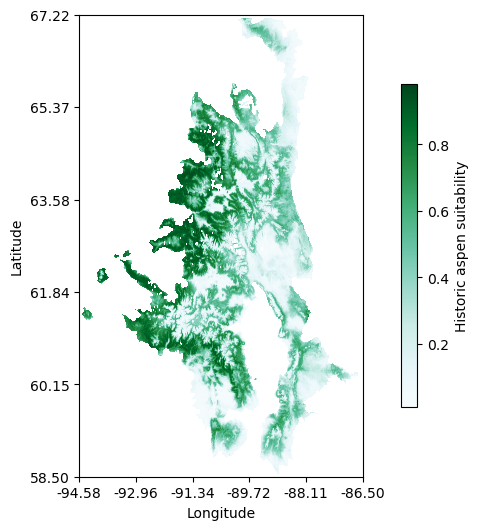

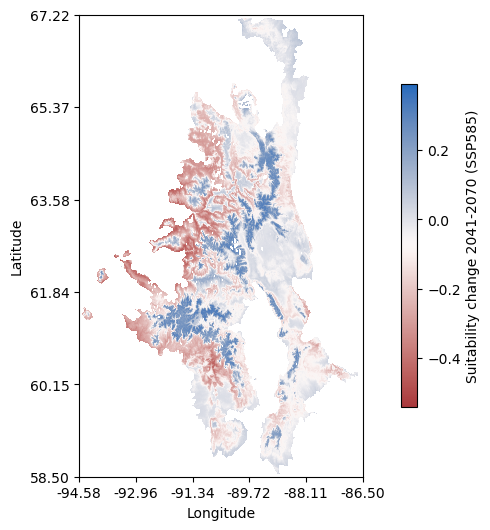

In [7]:
# load the future aspen suitability predictions
dir = os.path.join(projdir,'Aim3/data/spatial/raw/aspen_suitability/Predictions/')
# historical suitability
hist = os.path.join(dir,'predicted_historical_1981-2010_ensemble.tif')
# future suitability (SSP245 2041-2070)
ssp245 = os.path.join(dir,'predicted_SSP245_2041-2070_ensemble.tif')
# future suitability (SSP585 2041-2070)
ssp585 = os.path.join(dir,'predicted_SSP585_2041-2070_ensemble.tif')

# load each raster
hist_da = rxr.open_rasterio(hist, masked=True, cache=False).squeeze()
ssp245_da = rxr.open_rasterio(ssp245, masked=True, cache=False).squeeze()
ssp585_da = rxr.open_rasterio(ssp585, masked=True, cache=False).squeeze()

# calculate the change in suitability under both scenarios
change_SSP245 = ssp245_da - hist_da
change_SSP585 = ssp585_da - hist_da

# check the results
out_png = os.path.join(projdir, 'Aim3/figures/srm_aspen_suitability_historic.png')
plot_raster(
    hist_da, 
    legend_lab = "Historic aspen suitability",
    cmap = 'BuGn',
    save_file=True, out_png=out_png
)
out_png = os.path.join(projdir, 'Aim3/figures/srm_aspen_suitability_change_ssp585.png')
plot_raster(
    change_SSP585, 
    legend_lab = "Suitability change 2041-2070 (SSP585)", 
    cmap = 'vlag_r',
    save_file=True, out_png=out_png
)

In [8]:
change_SSP245.rio.crs

CRS.from_epsg(32613)

In [9]:
# calculate band statistics
# mean, standard deviation, percentiles

# create a list of rasters to calculate zonal stats
das = {
    'historic': hist_da, # historic (1981-2010) suitability
    'ssp245': ssp245_da, # raw suitability SSP245 2041-2070
    'ssp585': ssp585_da, # raw suitability SSP585 2041-2070
    'delta245': change_SSP245, # change SSP245 2041-2070
    'delta585': change_SSP585 # change SSP585 2041-2070
}

results = []
for key, da in das.items():
    print(f"Processing: {key}")
    # ensure the correct projection
    da_ = da.rio.reproject(proj) # matches grid
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=firesheds, 
        image_da=da_, 
        id_col='sfs_id', 
        stats=['mean'], # 'median','std','percentile_90'
        attr=key,
        ztype='continuous'
    )
    results.append(zs)

# concatenate the results
future_aspen = pd.concat([df.set_index("sfs_id") for df in results], axis=1).reset_index()
future_aspen.head()

Processing: historic
Processing: ssp245
Processing: ssp585
Processing: delta245
Processing: delta585


,sfs_id,historic_mean,ssp245_mean,ssp585_mean,delta245_mean,delta585_mean
0,20466,0.486227,0.283289,0.264404,-0.202938,-0.221823
1,20467,0.438678,0.232485,0.214744,-0.206193,-0.223933
2,20468,0.614530,0.331943,0.288274,-0.282587,-0.326256
3,20469,0.672996,0.492449,0.476654,-0.180547,-0.196342
4,21025,0.640499,0.464256,0.439779,-0.176243,-0.200719


In [10]:
# rename the columns
future_aspen = future_aspen.rename(
    columns={
        'historic_mean': 'historic',
        'ssp245_mean': 'ssp245',
        'ssp585_mean': 'ssp585',
        'delta245_mean': 'delta245',
        'delta585_mean': 'delta585'
    }
)

# join to the fire dataframe
firesheds_fa = pd.merge(firesheds, future_aspen, on="sfs_id", how="left")
firesheds_fa.head()

,fs_id,sfs_id,sfs_area_ha,fs_name,sfs_exposure,pct_disturbed,geometry,US_L4CODE,US_L4NAME,trend_area,trend_count,historic,ssp245,ssp585,delta245,delta585
0,2039,20466,10147.68,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1175586.440 1748339.700, -117...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504,0.486227,0.283289,0.264404,-0.202938,-0.221823
1,2039,20467,10380.96,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1165866.440 1748339.700, -116...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504,0.438678,0.232485,0.214744,-0.206193,-0.223933
2,2039,20468,10730.88,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1180986.440 1737539.700, -118...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504,0.614530,0.331943,0.288274,-0.282587,-0.326256
3,2039,20469,11314.08,"Blue Creek Point, Utah",0.000000,0.000000,"MULTIPOLYGON (((-1169106.440 1737539.700, -116...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504,0.672996,0.492449,0.476654,-0.180547,-0.196342
4,2097,21025,10964.16,"Indian Village, Utah",0.001366,9.739679,"MULTIPOLYGON (((-1174506.440 1727819.700, -117...",21c,Crystalline Mid-Elevation Forests,411.936265,0.034504,0.640499,0.464256,0.439779,-0.176243,-0.200719


In [11]:
len(firesheds_fa)

1714

In [12]:
# tidy up
del das, results, zs, hist_da, ssp245_da, ssp585_da, change_SSP245, change_SSP585, future_aspen
gc.collect()

133

## Sentinel-based aspen cover (ca. 2019)

From Cook et al. (2024), calculate the percent aspen canopy cover within gridcells. This should ideally be updated to 2023 ...

In [13]:
t0 = time.time()

# load the 10-m aspen map (classification)
aspen10_fp = os.path.join(projdir,'Aim1/data/spatial/mod/results/classification/s2aspen_distribution_10m_y2019_CookEtAl.tif')
aspen10 = rxr.open_rasterio(aspen10_fp, cache=False, chunks='auto', mask=True).squeeze()
print(f"\n{aspen10}\n")
print(aspen10.rio.crs)

# calculate zonal statistics
aspen10_grids = compute_band_stats(
    geoms=firesheds, 
    image_da=aspen10, 
    id_col='sfs_id', 
    attr='aspen10',
    ztype='categorical'
)

# only keep the count of aspen pixels
aspen10_grids = aspen10_grids[aspen10_grids['aspen10'] == 1]
# check the results
print(aspen10_grids.head())

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")


<xarray.DataArray (y: 95433, x: 64151)> Size: 6GB
dask.array<getitem, shape=(95433, 64151), dtype=uint8, chunksize=(2092, 64151), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 513kB -1.217e+06 -1.217e+06 ... -5.76e+05 -5.76e+05
  * y            (y) float64 763kB 2.309e+06 2.309e+06 ... 1.355e+06 1.355e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        1
    STATISTICS_MEAN:           0.015698091117366
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         0.1243047105006
    STATISTICS_VALID_PERCENT:  100
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0

EPSG:5070
    sfs_id  aspen10  count  total_pixels  pct_cover
1    20466        1     48       1017037   0.004720
3    20467        1   1519       1040365   0.146006
6    20469        1  73194       1133785   6.455721
8    21025        1   8995       1098901   0.8

In [14]:
aspen10_grids['pct_cover'].describe()

count    1637.000000
mean        5.736593
std         9.041754
min         0.000086
25%         0.218776
50%         1.792738
75%         6.837600
max        57.693693
Name: pct_cover, dtype: float64

In [15]:
# rename for clarity
aspen10_grids.rename(columns={
    'pct_cover': 'aspen10_pct',
    'count': 'aspen10_pixn'
}, inplace=True)

# merge back to the main grid data
firesheds_fa = pd.merge(
    firesheds_fa, aspen10_grids[['sfs_id','aspen10_pct','aspen10_pixn']], 
    on='sfs_id', how='left')
firesheds_fa.columns

Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn'],
      dtype='object')

In [16]:
len(firesheds_fa)

1714

In [17]:
del aspen10, aspen10_grids
gc.collect() # free memory

441

In [18]:
# load the patch metrics and join in
fp = os.path.join(projdir,'Aim3/data/tabular/firesheds_aspen10_patches.csv')
patches = pd.read_csv(fp)
patches.head()

,Unnamed: 0,class_val,number_of_patches,patch_density,largest_patch_index,sfs_id
0,0,1,86,3.815372,0.095384,20467
1,1,1,4,0.161778,0.010920,20466
2,2,1,1941,54.625124,2.078062,20469
3,3,1,1147,34.018549,2.622127,21247
4,4,1,274,6.027091,0.690916,21025


In [19]:
# tidy
patches = patches[['sfs_id', 'number_of_patches', 'patch_density', 'largest_patch_index']]
firesheds_fa = pd.merge(firesheds_fa, patches, on='sfs_id', how='left')
print(firesheds_fa.columns)
len(firesheds_fa)

Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn', 'number_of_patches', 'patch_density',
       'largest_patch_index'],
      dtype='object')


1714

## Built Environment Summaries

COMBUST, Microsoft Building Footprints, WorldPop population density/counts, and WUI classification (10-m)

In [20]:
# Contemporary COMBUST grid (combustible mass of the built environment)
combust_fp = os.path.join(projdir,'Aim3/data/spatial/raw/COMBUST/combustible_building_mass_t_2020_mean.tif')
# Miscrosoft building footprint counts (same grid as COMBUST)
msbf_fp = os.path.join(maindir,'earth-lab/opp-urban-fuels/data/spatial/mod/Microsoft/msbf_counts.tif')
# WorldPop population density estimates
wp_density_fp = os.path.join(projdir,'Aim3/data/spatial/raw/WorldPop/usa_pd_2020_1km.tif')
wp_count_fp = os.path.join(projdir,'Aim3/data/spatial/raw/WorldPop/srm_ppp_2020_constrained.tif')

# put the continuous rasters in a dictionary to calculate zonal stats
das = {
    'combust': combust_fp,
    'msbf_count': msbf_fp,
    'pop_density': wp_density_fp,
    'pop_count': wp_count_fp,
}

results = []
# map the dictionary, calculate zonal stats
for key, fp in das.items():
    print(f"Processing: {key}")
    # process the raster grid
    da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
    da = da.rio.reproject(proj) # ensure matching projection
    if key == 'pop_density':
        stat = ['max']
    else:
        stat = ['sum']
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=firesheds, 
        image_da=da, 
        id_col='sfs_id', 
        stats=stat, 
        attr=key,
        ztype='continuous'
    )
    results.append(zs)
    del da, zs
    
# concatenate the results
built_env_pop = pd.concat([df.set_index("sfs_id") for df in results], axis=1).reset_index()
built_env_pop.head()

Processing: combust
Processing: msbf_count
Processing: pop_density
Processing: pop_count


,sfs_id,combust_sum,msbf_count_sum,pop_density_max,pop_count_sum
0,20466,71.803413,16.0,0.097160,NaN
1,20467,40.710857,10.0,0.353301,NaN
2,20468,24.782980,10.0,0.097160,NaN
3,20469,0.000000,0.0,0.117208,NaN
4,21025,60.324951,13.0,0.004678,NaN


### Wildland Urban Interface/Intermix (SILVIS)

In [21]:
# load the results from "wui-summary.ipynb"
fp = os.path.join(projdir, 'Aim3/data/tabular/fireshed_wuiSILVIS_stats.csv')
wui = pd.read_csv(fp)
wui.drop(columns=['Unnamed: 0'], inplace=True)
wui.head()

,sfs_id,wui1,wui2,wui3,wui4,wui_dist_mean
0,20466,0.0,0.0,0.0,0.0,234.911944
1,20467,0.0,0.0,0.0,0.0,143.537877
2,20468,0.0,0.0,0.0,0.0,277.059693
3,20469,0.0,0.0,0.0,0.0,161.697882
4,21025,0.0,0.0,0.0,0.0,175.126415


In [22]:
# merge the built environment stats with the wui stats
wui_bltenv = pd.merge(built_env_pop, wui, on='sfs_id', how='left')
wui_bltenv.columns

Index(['sfs_id', 'combust_sum', 'msbf_count_sum', 'pop_density_max',
       'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4', 'wui_dist_mean'],
      dtype='object')

In [23]:
# merge to the future fire grid
firesheds_fa = pd.merge(firesheds_fa, wui_bltenv, on='sfs_id', how='left')
firesheds_fa.columns

Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn', 'number_of_patches', 'patch_density',
       'largest_patch_index', 'combust_sum', 'msbf_count_sum',
       'pop_density_max', 'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4',
       'wui_dist_mean'],
      dtype='object')

In [24]:
len(firesheds_fa)

1714

## Contemporary Fire Activity and Fire Risk 

### Ignition Causes

In [25]:
# load the fpa-fod ignitions data and get the total count
fpa_fp = os.path.join(projdir,'Aim3/data/spatial/mod/fire/srm_fpa_fod.gpkg')
fpa = gpd.read_file(fpa_fp)
fpa.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'geometry'],
      dtype='object')

In [26]:
print(fpa['FIRE_YEAR'].min())
print(fpa['FIRE_YEAR'].max())

1992
2020


In [27]:
fpa['NWCG_CAUSE_CLASSIFICATION'].unique()

array(['Natural', 'Human', 'Missing data/not specified/undetermined'],
      dtype=object)

In [28]:
# load the ICS (for 2021-2023) for Southern Rockies
ics = os.path.join(projdir,'Aim3/data/spatial/raw/ics/srm_ics209plus_to2023.gpkg')
ics = gpd.read_file(ics)
ics.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [29]:
# filter and prep the ICS
ics = ics[ics['START_YEAR'] > 2020]
ics.CAUSE.unique()

array(['H', 'L', 'U'], dtype=object)

In [30]:
ics_ = ics[['START_YEAR','CAUSE','FINAL_ACRES']].reset_index()
# replace the undetermined code
ics_['CAUSE'] = ics_['CAUSE'].replace({
    "U": "Undetermined",
    "H": "Human",
    "L": "Natural"
})
ics_['SOURCE'] = 'ICS209PLUS'
ics_.head()

,index,START_YEAR,CAUSE,FINAL_ACRES,SOURCE
0,25,2021,Human,8952.00,ICS209PLUS
1,26,2021,Natural,0.10,ICS209PLUS
2,27,2022,Natural,0.25,ICS209PLUS
3,495,2021,Natural,7586.00,ICS209PLUS
4,496,2021,Human,536.70,ICS209PLUS


In [31]:
fpa.rename(
    columns={
        'NWCG_CAUSE_CLASSIFICATION': 'CAUSE',
        'FIRE_YEAR': 'START_YEAR',
        'FIRE_SIZE': 'FINAL_ACRES',
        'OBJECTID': 'index'
    }, inplace=True
)
fpa_ = fpa[['index','START_YEAR','CAUSE','FINAL_ACRES']]
fpa_['SOURCE'] = 'FPA-FOD'
fpa_.CAUSE.unique()

array(['Natural', 'Human', 'Missing data/not specified/undetermined'],
      dtype=object)

In [32]:
# prep and merge FPA and ICS
fpa_['CAUSE'] = fpa_['CAUSE'].replace(
    "Missing data/not specified/undetermined", "Undetermined"
)
# merge
ics_fpa = pd.concat([fpa_, ics_], axis=0)
ics_fpa.columns

Index(['index', 'START_YEAR', 'CAUSE', 'FINAL_ACRES', 'SOURCE'], dtype='object')

In [33]:
ics_fpa.head()

,index,START_YEAR,CAUSE,FINAL_ACRES,SOURCE
0,26619,2007,Natural,0.10,FPA-FOD
1,31852,2008,Natural,0.25,FPA-FOD
2,144199,2001,Natural,0.50,FPA-FOD
3,144217,2001,Natural,0.10,FPA-FOD
4,68258,1994,Natural,0.10,FPA-FOD


In [34]:
# calculate the area burned by ignition cause by year
cause_burned = (
    ics_fpa.groupby(['START_YEAR','CAUSE'], as_index=False)
    .agg(
        area_burned=('FINAL_ACRES','sum'),
        fire_count=('index', 'count')   
    )
)
# check the results
cause_burned.head()

,START_YEAR,CAUSE,area_burned,fire_count
0,1992,Human,1606.6,341
1,1992,Natural,812.0,363
2,1992,Undetermined,202.7,68
3,1993,Human,1141.6,362
4,1993,Natural,8726.0,393


In [35]:
# get the percent by cause
total = cause_burned.groupby("CAUSE")["area_burned"].sum()
sum = total.sum()
(total / sum) * 100

CAUSE
Human           55.120529
Natural         33.790534
Undetermined    11.088938
Name: area_burned, dtype: float64

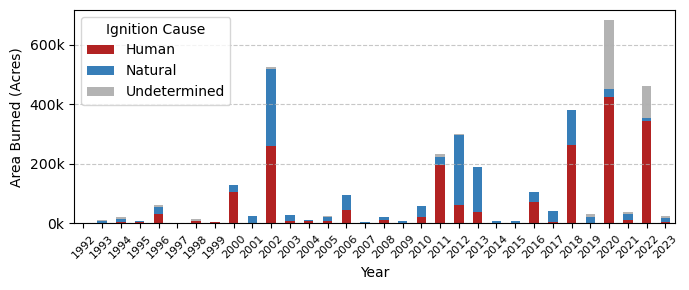

In [36]:
# make the plot

# Function to format colorbar labels with 'k' notation
def format_ticks(value, _):
    return f'{int(value / 1000)}k'

formatter = FuncFormatter(format_ticks)

# define color mapping
color_map = {
    "Human": "#B22222",        
    "Natural": "#377EB8",      
    "Undetermined": "#B3B3B3"  
}
# map the colors
colors = [color_map.get(cause, "#CCCCCC") for cause in cause_burned["CAUSE"]]

# Pivot data for stacking
cause_burned_p = cause_burned.pivot(
    index="START_YEAR", 
    columns="CAUSE", 
    values="area_burned").fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(7, 3))
cause_burned_p.plot(
    kind="bar", 
    stacked=True, 
    color=[color_map[c] for c in cause_burned_p.columns],  # FIX: use color_map, not cause_colors
    ax=ax
)

# Labels and styling
ax.set_xlabel("Year")
ax.set_ylabel("Area Burned (Acres)")
ax.legend(title="Ignition Cause")

# Apply custom formatting to y-axis
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(rotation=45, size=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'Aim3/figures/ICS-FPA_annualBurnedArea_byCause.png'), dpi=300, bbox_inches='tight')

plt.show()

### Burned Area

In [37]:
# load burned area and calculate the cumulative area burned
mtbs_fp = os.path.join(projdir,'Aim3/data/spatial/mod/fire/srm_mtbs_perims_dd.gpkg')
mtbs = gpd.read_file(mtbs_fp)
mtbs.columns

Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')

In [38]:
mtbs['Ig_Date'] = pd.to_datetime(mtbs['Ig_Date'])
mtbs['Fire_Year'] = mtbs['Ig_Date'].dt.year
mtbs[['Ig_Date','Fire_Year']].head()

,Ig_Date,Fire_Year
0,1987-07-07,1987
1,1987-07-02,1987
2,1989-09-25,1989
3,1989-07-09,1989
4,1989-07-08,1989


In [39]:
print(mtbs['Fire_Year'].min())
print(mtbs['Fire_Year'].max())

1984
2023


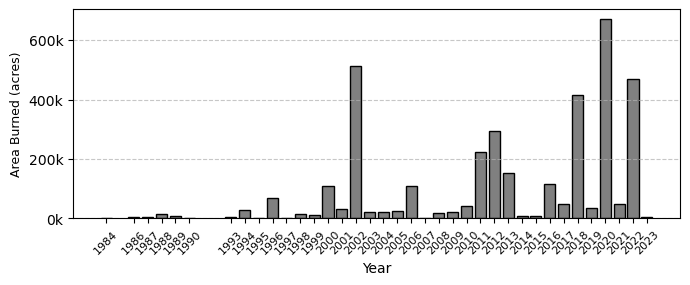

In [40]:
# plot the annual area burned
burned_area = mtbs.groupby('Fire_Year')['BurnBndAc'].sum().reset_index()

# Function to format colorbar labels with 'k' notation
def format_ticks(value, _):
    return f'{int(value / 1000)}k'

formatter = FuncFormatter(format_ticks)

# Plot the results
plt.figure(figsize=(7, 3))
plt.bar(burned_area['Fire_Year'], burned_area['BurnBndAc'], color='grey', edgecolor='black')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Area Burned (acres)', fontsize=9)
plt.xticks(burned_area['Fire_Year'], rotation=45, size=8)

# Apply custom formatting to y-axis
plt.gca().yaxis.set_major_formatter(formatter)
# plt.ylim(10000, None)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'Aim3/figures/MTBS_annualBurnedArea.png'), dpi=300, bbox_inches='tight')

plt.show()

In [41]:
# calculate the cumulative previous area burned
mtbs = mtbs.to_crs(proj) # ensure the correct CRS
mtbs_in_grid = gpd.overlay(mtbs, firesheds, how='intersection') # perform the overlay

# get the cumulative burned area in each grid cell
mtbs_in_grid['burned_area_c'] = mtbs_in_grid.geometry.area
burned_area_c = mtbs_in_grid.groupby('sfs_id', as_index=False)['burned_area_c'].sum()
# calculate the cumulative percent burned
# get the gridcell area
df = firesheds.copy()
df['sfs_area'] = df.geometry.area

# merge burned area summary back to grid cells
burned_area_c = df[['sfs_id','sfs_area']].merge(burned_area_c, on='sfs_id', how='left')
# fill NaN values (for grid cells with no fire) with 0
burned_area_c['burned_area_c'] = burned_area_c['burned_area_c'].fillna(0)
# Compute percentage of each grid cell burned
burned_area_c['burned_pct_c'] = (burned_area_c['burned_area_c'] / burned_area_c['sfs_area']) * 100

# merge back to the main grid data
firesheds_fa = pd.merge(firesheds_fa, burned_area_c, on='sfs_id', how='left')
firesheds_fa.columns

Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn', 'number_of_patches', 'patch_density',
       'largest_patch_index', 'combust_sum', 'msbf_count_sum',
       'pop_density_max', 'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4',
       'wui_dist_mean', 'sfs_area', 'burned_area_c', 'burned_pct_c'],
      dtype='object')

In [42]:
len(firesheds_fa)

1714

In [43]:
del mtbs, mtbs_in_grid, burned_area_c, df
gc.collect()

63

### Wildfire Hazard Potential (version 2023)

In [44]:
# load the wildfire hazard potential
fp = os.path.join(projdir,'Aim3/data/spatial/raw/fsim/whp/whp2023_GeoTIF/whp2023_cnt_conus.tif')
whp = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
whp = whp.rio.reproject(proj) # matches grid
# calculate the zonal stats
whp_zs = compute_band_stats(
    geoms=firesheds, 
    image_da=whp, 
    id_col='sfs_id', 
    stats=['percentile_90'], # 'median','std','percentile_90'
    attr='whp',
    ztype='continuous'
)
print(whp_zs.head())
# merge back to the main grid data
whp_zs.rename(columns={'whp_percentile_90': 'whp_p90'}, inplace = True) # tidy columns name first
firesheds_fa = pd.merge(firesheds_fa, whp_zs, on='sfs_id', how='left')
print(firesheds_fa.columns)
# clean up
del whp_zs, whp
gc.collect()

   sfs_id  whp_percentile_90
0   20466              960.4
1   20467              919.6
2   20468              968.0
3   20469             1462.0
4   21025             1458.8
Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn', 'number_of_patches', 'patch_density',
       'largest_patch_index', 'combust_sum', 'msbf_count_sum',
       'pop_density_max', 'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4',
       'wui_dist_mean', 'sfs_area', 'burned_area_c', 'burned_pct_c',
       'whp_p90'],
      dtype='object')


31

### Conditional Flame Length (CFL)

In [45]:
# load the conditional flame length
fp = os.path.join(projdir,'Aim3/data/spatial/raw/fsim/CFL_CONUS/CFL_srm.tif')
cfl = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
cfl = cfl.rio.reproject(proj) # matches grid
# calculate the zonal stats
cfl_zs = compute_band_stats(
    geoms=firesheds, 
    image_da=cfl, 
    id_col='sfs_id', 
    stats=['percentile_90'], # 'median','std','percentile_90'
    attr='cfl',
    ztype='continuous'
)
print(cfl_zs.head())
# merge back to the main grid data
cfl_zs.rename(columns={'cfl_percentile_90': 'cfl_p90'}, inplace = True) # tidy columns name first
firesheds_fa = pd.merge(firesheds_fa, cfl_zs, on='sfs_id', how='left')
print(firesheds_fa.columns)
# clean up
del cfl, cfl_zs

   sfs_id  cfl_percentile_90
0   20466          23.414985
1   20467          22.003370
2   20468          31.041842
3   20469          49.454799
4   21025          30.485267
Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn', 'number_of_patches', 'patch_density',
       'largest_patch_index', 'combust_sum', 'msbf_count_sum',
       'pop_density_max', 'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4',
       'wui_dist_mean', 'sfs_area', 'burned_area_c', 'burned_pct_c', 'whp_p90',
       'cfl_p90'],
      dtype='object')


### Housing Unit Impact (HUI)

In [46]:
# load the wildfire hazard potential
fp = os.path.join(projdir,'Aim3/data/spatial/raw/fsim/housing_unit/hui/hui_srm.tif')
hui = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
hui = hui.rio.reproject(proj) # matches grid
# calculate the zonal stats
hui_zs = compute_band_stats(
    geoms=firesheds, 
    image_da=hui, 
    id_col='sfs_id', 
    stats=['percentile_90'], # 'median','std','percentile_90'
    attr='hui',
    ztype='continuous'
)
print(hui_zs.head())
# merge back to the main grid data
hui_zs.rename(columns={'hui_percentile_90': 'hui_p90'}, inplace = True) # tidy columns name first
firesheds_fa = pd.merge(firesheds_fa, hui_zs, on='sfs_id', how='left')
firesheds_fa.columns
# clean up
del hui, hui_zs

   sfs_id  hui_percentile_90
0   20466           127534.8
1   20467           111468.0
2   20468                NaN
3   20469                NaN
4   21025                NaN


## LANDFIRE Existing Vegetation (ca. 2023)

In [47]:
# list out the landfire GeoTIFFs
# veg Type, Height, and Cover
lf_dir = os.path.join(projdir,'Aim3/data/spatial/mod/landfire/')
lf_tiffs = list_files(lf_dir, '*.tif', recursive=True)
lf_tiffs = [f for f in lf_tiffs if any(sub in f for sub in ['cc', 'ch', 'evt'])]
print([os.path.basename(f) for f in lf_tiffs])

['srm_lf23_evt_240.tif', 'srm_lc23_cc_240.tif', 'srm_lc23_ch_240.tif']


In [48]:
# calculate the percent cover from EVT classes
evt = rxr.open_rasterio(lf_tiffs[0], masked=True).squeeze()
print(evt.rio.crs)

# calculate the percent cover of WUI classes for each grid
t0 = time.time()

# see __functions.py
evt_grid = compute_band_stats(firesheds, evt, 'sfs_id', attr='evt')
# tidy columns in the summary table
evt_grid['count'] = evt_grid['count'].astype(int)
evt_grid['total_pixels'] = evt_grid['total_pixels'].astype(int)
evt_grid.rename(columns = {'count': 'evt_pixels'}, inplace=True)
print(evt_grid.head())

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del evt # clean up 
gc.collect()

EPSG:5070
   sfs_id   evt  evt_pixels  total_pixels  pct_cover
0   20466  7011        1217        113509   1.072162
1   20466  7016       69616        113509  61.330820
2   20466  7051        3006        113509   2.648248
3   20466  7052         374        113509   0.329489
4   20466  7054        3777        113509   3.327489

Total elapsed time: 0.30 minutes.

~~~~~~~~~~



33

In [49]:
# load the lookup table
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2023/LF2023_EVT_240_CONUS/CSV_Data/LF23_EVT_240.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)
# join to the grid
evt_grid = pd.merge(evt_grid, lookup, left_on='evt', right_on='VALUE', how='left')
print(evt_grid[['sfs_id','evt','evt_pixels','pct_cover','EVT_NAME','SAF_SRM']].head())
# save this file out
out_fp = os.path.join(projdir, 'Aim3/data/tabular/firesheds_evt_summary.csv')
evt_grid.to_csv(out_fp)
print(f"Saved to: \n{out_fp}")

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')
   sfs_id   evt  evt_pixels  pct_cover  \
0   20466  7011        1217   1.072162   
1   20466  7016       69616  61.330820   
2   20466  7051        3006   2.648248   
3   20466  7052         374   0.329489   
4   20466  7054        3777   3.327489   

                                            EVT_NAME  \
0           Rocky Mountain Aspen Forest and Woodland   
1           Colorado Plateau Pinyon-Juniper Woodland   
2  Southern Rocky Mountain Dry-Mesic Montane Mixe...   
3  Southern Rocky Mountain Mesic Montane Mixed Co...   
4    Southern Rocky Mountain Ponderosa Pine Woodland   

                                 SAF_SRM  
0                         SAF 217: Aspen  
1  SRM 504: Juniper-Pinyon Pine Woodland  
2          SAF 210: Interior Douglas-Fir  
3    

In [50]:
# tidy the SAF column
evt_grid['SAF_SRM'] = evt_grid['SAF_SRM'].str.split(":", n=1).str[1].str.strip()
unique_evt = evt_grid['SAF_SRM'].unique()
unique_evt

array(['Aspen', 'Juniper-Pinyon Pine Woodland', 'Interior Douglas-Fir',
       'White Fir', 'Interior Ponderosa Pine',
       'Engelmann Spruce-Subalpine Fir', 'Bristlecone Pine',
       'Black Sagebrush', 'Saltbush-Greasewood', 'Blackbush',
       'Wyoming Big Sagebrush', 'Salt Desert Shrub',
       'Chokecherry-Serviceberry-Rose', 'Sandsage Prairie', 'Gambel oak',
       'Mountain Big Sagebrush', 'Grama-Galetta', 'Tall Forb',
       'Alpine Rangeland', 'Developed', 'Agriculture',
       'Sparsely Vegetated', 'Western Herbaceous Wetland',
       'Cottonwood-Willow', 'Riparian',
       'Introduced Upland Vegetation - Herbaceous',
       'Introduced Woody Wetlands and Riparian Vegetation',
       'Introduced Upland Vegetation - Shrub',
       'Introduced Herbaceous Wetland and Riparian Vegetation', 'Water',
       'Limber Pine', 'Curlleaf Mountain-Mahogany',
       'Big Sagebrush-Bluebunch Wheatgrass',
       'Rough Fescue-Bluebunch Wheatgrass',
       'Wheatgrass-Bluestem-Needlegrass',



Species making up 97% of the totalat least 2%: 

                           SAF_SRM  evt_pixels  fraction  c_fraction
16  Engelmann Spruce-Subalpine Fir    25682568  0.129804    0.129804
21         Interior Ponderosa Pine    24346126  0.123050    0.252854
26    Juniper-Pinyon Pine Woodland    17838418  0.090159    0.343013
30          Mountain Big Sagebrush    16000665  0.080870    0.423883
2                            Aspen    15420116  0.077936    0.501819
1                 Alpine Rangeland    11623952  0.058750    0.560569
17                      Gambel oak    10356199  0.052342    0.612911
45           Wyoming Big Sagebrush     8901414  0.044989    0.657900
20            Interior Douglas-Fir     8847615  0.044717    0.702618
29                  Lodgepole Pine     8303496  0.041967    0.744585
0                      Agriculture     5702092  0.028819    0.773404
39              Sparsely Vegetated     5190209  0.026232    0.799637
11   Chokecherry-Serviceberry-Rose     5094268  0.02

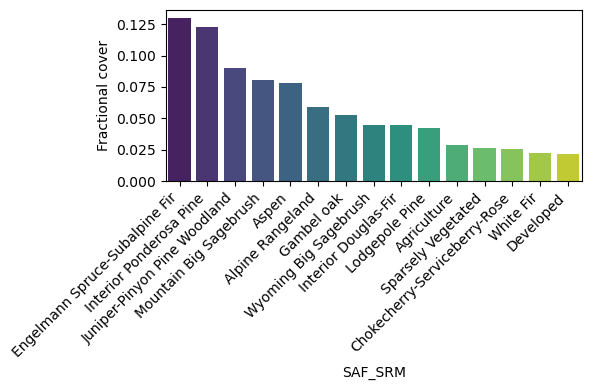

245

In [51]:
# gather the top 97% of EVTs
# Create a histogram of the forest species (prevalence)
fortyp = evt_grid.copy() # make a copy to work with
# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('SAF_SRM')['evt_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['evt_pixels'] / spp_pr['evt_pixels'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['fraction'] > 0.02]
print(f"\n\nSpecies making up 97% of the totalat least 2%: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SAF_SRM', y='fraction', palette='viridis')
plt.xlabel('SAF_SRM')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# clean up
del fortyp, spp_pr
gc.collect()

In [52]:
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'pinyon|juniper': 'pinon_juniper',
    'engelmann|subalpine': 'spruce_fir',
    'ponderosa': 'ponderosa', 
    'lodgepole': 'lodgepole',
    'sagebrush': 'sagebrush',
    'aspen': 'aspen',
    'douglas-fir': 'douglas_fir',
    'white fir': 'white_fir',
    'gambel': 'gambel_oak',
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = evt_grid[evt_grid['SAF_SRM'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['SAF_SRM'].unique()}
    )
    del spp
    
# Apply the remap to create a new grouped species column
evt_grid['SAF_SRM_gp'] = evt_grid['SAF_SRM'].map(spp_remap).fillna('Other')
# Verify the updated species groups
print(evt_grid[['sfs_id', 'SAF_SRM', 'SAF_SRM_gp', 'pct_cover']].head(8))
print(f"\n{evt_grid.columns}")

   sfs_id                         SAF_SRM     SAF_SRM_gp  pct_cover
0   20466                           Aspen          aspen   1.072162
1   20466    Juniper-Pinyon Pine Woodland  pinon_juniper  61.330820
2   20466            Interior Douglas-Fir    douglas_fir   2.648248
3   20466                       White Fir      white_fir   0.329489
4   20466         Interior Ponderosa Pine      ponderosa   3.327489
5   20466  Engelmann Spruce-Subalpine Fir     spruce_fir   0.030835
6   20466                Bristlecone Pine          Other   0.000881
7   20466                           Aspen          aspen   0.170031

Index(['sfs_id', 'evt', 'evt_pixels', 'total_pixels', 'pct_cover', 'VALUE',
       'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF', 'EVT_PHYS',
       'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS', 'EVT_SBCLS',
       'R', 'G', 'B', 'RED', 'GREEN', 'BLUE', 'SAF_SRM_gp'],
      dtype='object')


In [53]:
evt_grid['pct_cover'].describe()

count    78418.000000
mean         2.185723
std          7.195677
min          0.000619
25%          0.009819
50%          0.090086
75%          0.774964
max         90.189075
Name: pct_cover, dtype: float64

In [54]:
# Pivot: Fireshed ID as index, Forest Type as columns, Percent Cover as values
evt_w = evt_grid.pivot_table(
    index='sfs_id', 
    columns='SAF_SRM_gp', 
    values='pct_cover', 
    aggfunc='sum'
)

# Fill missing values with 0 (firesheds without that forest type)
evt_w = evt_w.fillna(0).reset_index()
evt_w.drop(columns=['Other'], inplace=True)
evt_w.head()

SAF_SRM_gp,sfs_id,aspen,douglas_fir,gambel_oak,lodgepole,pinon_juniper,ponderosa,sagebrush,spruce_fir,white_fir
0,12054,0.150802,0.064153,0.0,0.000000,0.0,8.720683,56.538221,0.000000,0.000000
1,12055,0.035174,0.000000,0.0,0.000000,0.0,1.725618,53.708321,0.000000,0.000000
2,12075,0.000000,0.000000,0.0,0.000000,0.0,0.270351,52.501352,0.000000,0.000000
3,12076,1.215872,5.102086,0.0,2.757503,0.0,12.016094,32.939488,0.945581,0.042261
4,12077,4.120873,8.104852,0.0,7.251422,0.0,24.572698,26.129368,2.710483,0.093087


In [55]:
# gather the top three most dominant vegetation types

# function to get the top X by percent cover
def dom_spps(df):
    top_three = df.nlargest(4, 'pct_cover')  # Get top three by percent cover
    return pd.Series({
        'dom_evt1': top_three.iloc[0]['EVT_NAME'] if len(top_three) > 0 else None,
        'dom_evt2': top_three.iloc[1]['EVT_NAME'] if len(top_three) > 1 else None,
        'dom_evt3': top_three.iloc[2]['EVT_NAME'] if len(top_three) > 2 else None,
        'dom_evt4': top_three.iloc[3]['EVT_NAME'] if len(top_three) > 3 else None
    })

# Apply function per grid_id
dom_evts = evt_grid.groupby('sfs_id').apply(dom_spps).reset_index()
dom_evts.head(10)

,sfs_id,dom_evt1,dom_evt2,dom_evt3,dom_evt4
0,12054,Inter-Mountain Basins Big Sagebrush Steppe,Inter-Mountain Basins Montane Sagebrush Steppe,Rocky Mountain Lower Montane-Foothill Shrubland,Southern Rocky Mountain Ponderosa Pine Woodland
1,12055,Inter-Mountain Basins Big Sagebrush Steppe,Western Cool Temperate Pasture and Hayland,Inter-Mountain Basins Big Sagebrush Shrubland,Inter-Mountain Basins Montane Sagebrush Steppe
2,12075,Inter-Mountain Basins Big Sagebrush Steppe,Northwestern Great Plains Mixedgrass Prairie,Western Great Plains Badlands,Western Cool Temperate Pasture and Hayland
3,12076,Northwestern Great Plains Mixedgrass Prairie,Inter-Mountain Basins Big Sagebrush Steppe,Inter-Mountain Basins Montane Sagebrush Steppe,Southern Rocky Mountain Ponderosa Pine Woodland
4,12077,Southern Rocky Mountain Ponderosa Pine Woodland,Inter-Mountain Basins Montane Sagebrush Steppe,Northwestern Great Plains Mixedgrass Prairie,Rocky Mountain Lower Montane-Foothill Shrubland
5,12078,Northwestern Great Plains Mixedgrass Prairie,Inter-Mountain Basins Big Sagebrush Steppe,Inter-Mountain Basins Montane Sagebrush Steppe,Western Cool Temperate Pasture and Hayland
6,12263,Inter-Mountain Basins Big Sagebrush Steppe,Northwestern Great Plains Mixedgrass Prairie,Western Great Plains Sand Prairie,Northwestern Great Plains Riparian Herbaceous
7,12264,Northwestern Great Plains Mixedgrass Prairie,Inter-Mountain Basins Big Sagebrush Steppe,Western Cool Temperate Close Grown Crop,Western Cool Temperate Pasture and Hayland
8,12266,Rocky Mountain Lower Montane-Foothill Shrubland,Northwestern Great Plains Mixedgrass Prairie,Inter-Mountain Basins Montane Sagebrush Steppe,Southern Rocky Mountain Ponderosa Pine Woodland
9,12267,Northwestern Great Plains Mixedgrass Prairie,Inter-Mountain Basins Big Sagebrush Steppe,Western Cool Temperate Close Grown Crop,Western Cool Temperate Pasture and Hayland


In [56]:
# merge the landcover data
evt_summary = pd.merge(dom_evts, evt_w, on='sfs_id', how='left')
evt_summary.columns

Index(['sfs_id', 'dom_evt1', 'dom_evt2', 'dom_evt3', 'dom_evt4', 'aspen',
       'douglas_fir', 'gambel_oak', 'lodgepole', 'pinon_juniper', 'ponderosa',
       'sagebrush', 'spruce_fir', 'white_fir'],
      dtype='object')

In [57]:
# calculate the continuous summaries (forest canopy percent and height)
ccs = {
    'forest_cc': lf_tiffs[1],
    'forest_ch': lf_tiffs[2]
}
results = [] # store results
for key, fp in ccs.items():
    print(f"Processing: {os.path.basename(fp)}")
    da = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=firesheds, 
        image_da=da, 
        id_col='sfs_id', 
        stats=['mean'], 
        attr=key,
        ztype='continuous'
    )
    results.append(zs)
    del da, zs

# concatenate the results
fc_summary = pd.concat([df.set_index("sfs_id") for df in results], axis=1).reset_index()
fc_summary.head()

Processing: srm_lc23_cc_240.tif
Processing: srm_lc23_ch_240.tif


,sfs_id,forest_cc_mean,forest_ch_mean
0,20466,15.146464,49.989692
1,20467,12.133961,36.158086
2,20468,28.423995,111.726890
3,20469,36.665784,113.228805
4,21025,23.595795,78.472357


In [58]:
# join the LANDFIRE summaries
lf_summary = pd.merge(evt_summary, fc_summary, on='sfs_id', how='left')
lf_summary.columns

Index(['sfs_id', 'dom_evt1', 'dom_evt2', 'dom_evt3', 'dom_evt4', 'aspen',
       'douglas_fir', 'gambel_oak', 'lodgepole', 'pinon_juniper', 'ponderosa',
       'sagebrush', 'spruce_fir', 'white_fir', 'forest_cc_mean',
       'forest_ch_mean'],
      dtype='object')

In [59]:
# join to the main grid, export
firesheds_fa = pd.merge(firesheds_fa, lf_summary, on='sfs_id', how='left')
print(firesheds_fa.columns)

Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn', 'number_of_patches', 'patch_density',
       'largest_patch_index', 'combust_sum', 'msbf_count_sum',
       'pop_density_max', 'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4',
       'wui_dist_mean', 'sfs_area', 'burned_area_c', 'burned_pct_c', 'whp_p90',
       'cfl_p90', 'hui_p90', 'dom_evt1', 'dom_evt2', 'dom_evt3', 'dom_evt4',
       'aspen', 'douglas_fir', 'gambel_oak', 'lodgepole', 'pinon_juniper',
       'ponderosa', 'sagebrush', 'spruce_fir', 'white_fir', 'forest_cc_mean',
       'forest_ch_mean'],
      dtype='object')


In [60]:
print(len(lf_summary))
print(len(firesheds_fa))

1714
1714


In [61]:
# proportion forested
# Save as a GeoTIFF
fp = os.path.join(projdir, "Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
print(forest_mask)

# calculate the grid-level forest percent
forest_pct = compute_band_stats(firesheds, forest_mask, 'sfs_id', attr='forest')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
# retain just forest pixels
forest_pct = forest_pct[forest_pct['forest'] == 1] # just forest pixels
forest_pct = forest_pct[['sfs_id','forest_pixels','forest_pct']]
forest_pct.head()

<xarray.DataArray (y: 28724, x: 17006)> Size: 2GB
dask.array<getitem, shape=(28724, 17006), dtype=float32, chunksize=(3946, 17006), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 136kB -1.193e+06 -1.193e+06 ... -6.831e+05
  * y            (y) float64 230kB 2.253e+06 2.253e+06 ... 1.392e+06 1.392e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


,sfs_id,forest_pixels,forest_pct
1,20466,113509,69.474667
3,20467,116101,55.442244
5,20468,120025,90.025411
7,20469,126505,87.369669
9,21025,122653,77.522767


In [62]:
len(firesheds_fa)

1714

In [63]:
# join to the main grid, export
firesheds_fa = pd.merge(firesheds_fa, forest_pct, on='sfs_id', how='left')
print(firesheds_fa.columns)
# export
out_fp = os.path.join(projdir, 'Aim3/data/spatial/mod/srm_firesheds_model_data.gpkg')
firesheds_fa.to_file(out_fp)
print(f"Saved to: \n{out_fp}")

Index(['fs_id', 'sfs_id', 'sfs_area_ha', 'fs_name', 'sfs_exposure',
       'pct_disturbed', 'geometry', 'US_L4CODE', 'US_L4NAME', 'trend_area',
       'trend_count', 'historic', 'ssp245', 'ssp585', 'delta245', 'delta585',
       'aspen10_pct', 'aspen10_pixn', 'number_of_patches', 'patch_density',
       'largest_patch_index', 'combust_sum', 'msbf_count_sum',
       'pop_density_max', 'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4',
       'wui_dist_mean', 'sfs_area', 'burned_area_c', 'burned_pct_c', 'whp_p90',
       'cfl_p90', 'hui_p90', 'dom_evt1', 'dom_evt2', 'dom_evt3', 'dom_evt4',
       'aspen', 'douglas_fir', 'gambel_oak', 'lodgepole', 'pinon_juniper',
       'ponderosa', 'sagebrush', 'spruce_fir', 'white_fir', 'forest_cc_mean',
       'forest_ch_mean', 'forest_pixels', 'forest_pct'],
      dtype='object')
Saved to: 
/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim3/data/spatial/mod/srm_firesheds_model_data.gpkg
